In [1]:
%load_ext autoreload
%autoreload 2
from src.datamodules.CarsDataModule import CarsDataset,CarsDataModule
import pandas as pd
from pathlib import Path

In [4]:
# ds = CarsDataset()

In [2]:
from icevision.all import *


In [3]:
from icevision.all import *
import pandas as pd


class CarsDatasetParser(Parser):
    def __init__(self, template_record, data_dir):
        super().__init__(template_record=template_record)
        self.data_dir = data_dir
        self.df = pd.read_csv(data_dir / "train_solution_bounding_boxes.csv")
        self.class_map = ClassMap(["car"])
    
    def __iter__(self) -> Any:
        for o in self.df.itertuples():
            yield o
    
    def __len__(self) -> int:
        return len(self.df)
    
    def record_id(self, o) -> Hashable:
        return o.image
    
    def parse_fields(self, o, record, is_new):
        if is_new:
            record.set_filepath(self.data_dir / 'training_images' / o.image)
            record.set_img_size(ImgSize(width=o.image_width, height=o.image_height))
            record.detection.set_class_map(self.class_map)
        record.detection.add_bboxes([BBox.from_xyxy(o.xmin, o.ymin, o.xmax, o.ymax)])
        record.detection.add_labels(["car"])

In [4]:

class DentalCariesParser(Parser):
    def __init__(self, template_record, data_dir):
        super().__init__(template_record=template_record)
        self.data_dir = data_dir
        self.df = pd.read_csv(data_dir / "annotations.csv")
        self.class_map = ClassMap(["decay"])
    
    def __iter__(self) -> Any:
        for o in self.df.itertuples():
            yield o
    
    def __len__(self) -> int:
        return len(self.df)
    
    def record_id(self, o) -> Hashable:
        return o.image
    
    def parse_fields(self, o, record, is_new):
        if is_new:
            record.set_filepath(self.data_dir / 'images' / o.image)
            record.set_img_size(ImgSize(width=o.image_width, height=o.image_height))
            record.detection.set_class_map(self.class_map)
        if not o.noobject:
            record.detection.add_bboxes([BBox.from_xyxy(o.xmin, o.ymin, o.xmax, o.ymax)])
            record.detection.add_labels(["decay"])

100%|██████████| 3079/3079 [00:00<00:00, 7554.09it/s] 
INFO     - Autofixing records | icevision.parsers.parser:parse:122
100%|██████████| 1626/1626 [00:00<00:00, 25763.81it/s]


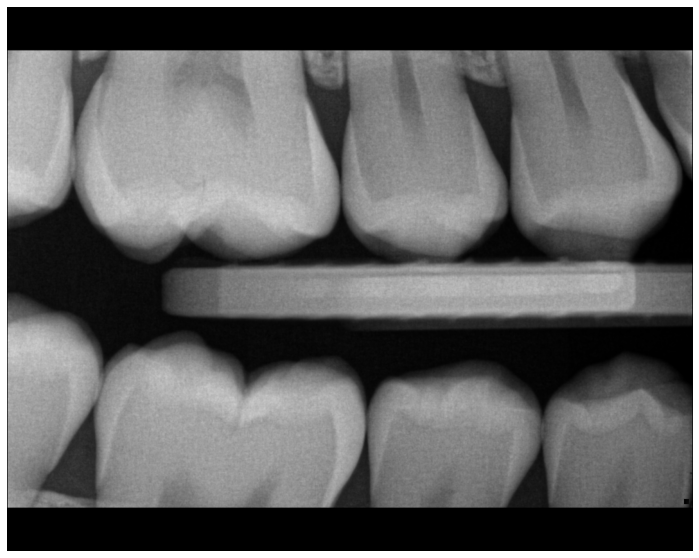

In [5]:
template_record = ObjectDetectionRecord()
parser = DentalCariesParser(template_record, Path("/home/kuntik/carries_dataset"))
train_record, valid_record = parser.parse()
show_record(train_record[2], figsize=(14,10))

  0%|          | 0/559 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


  0%|          | 0/355 [00:00<?, ?it/s]

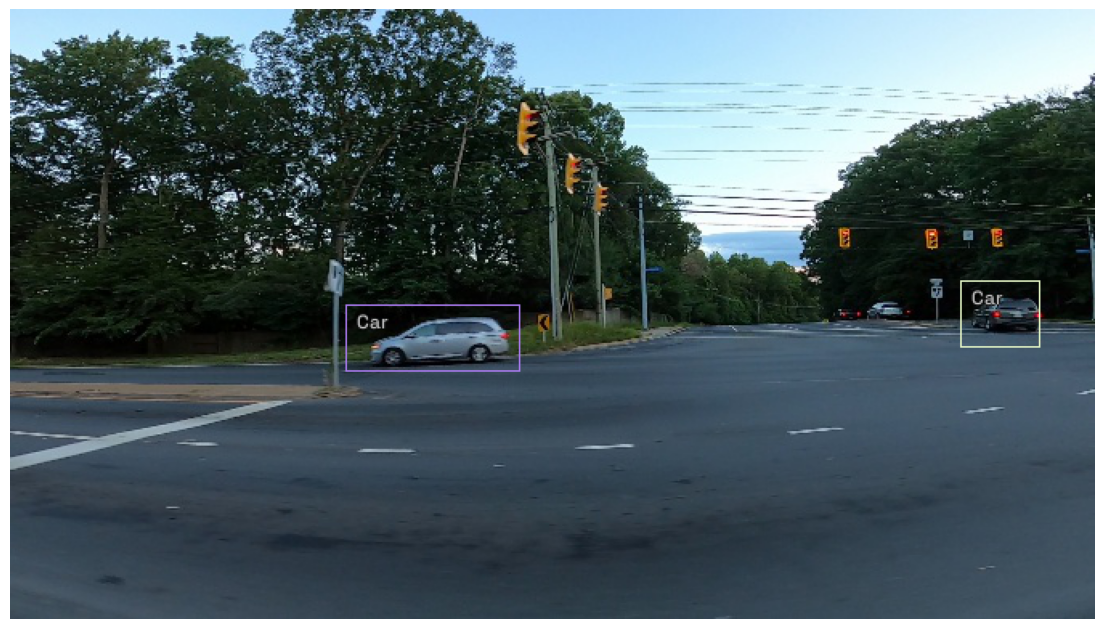

In [17]:
parser = CarsDatasetParser(template_record,  Path("/home.stud/kuntluka/dataset/cars/data"))
train_record, valid_record = parser.parse()
show_record(train_rec[1], figsize=(14,10))

In [6]:
image_size = 512
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=image_size, presize=600), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(image_size), tfms.A.Normalize()])
train_ds = Dataset(train_record, train_tfms)
valid_ds = Dataset(valid_record, valid_tfms)

In [7]:
model_type = models.ross.efficientdet
backbone = model_type.backbones.tf_lite0(pretrained=True)
x_args = {'img_size' : image_size}
det_model = model_type.model(backbone=backbone, num_classes=len(parser.class_map), **x_args)
train_dl = model_type.train_dl(train_ds, batch_size=8, num_workers=4, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=8, num_workers=4, shuffle=False)


1300

In [34]:
import pytorch_lightning as pl
from src.modules.EfficientDetModule import EfficientDetModule
model = EfficientDetModule(det_model, 1e-3)
trainer = pl.Trainer(accelerator='cpu', max_epochs=30)
dm = CariesDataModule("/home/kuntik/carries_dataset", 512, model_type)
dm.setup()
t = dm.train_dataloader()
trainer.fit(model, dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
100%|██████████| 3079/3079 [00:00<00:00, 4336.31it/s]
INFO     - Autofixing records | icevision.parsers.parser:parse:122
100%|██████████| 1626/1626 [00:00<00:00, 13082.21it/s]

  | Name  | Type          | Params
----------------------------------------
0 | model | DetBenchTrain | 3.2 M 
----------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
12.757    Total estimated model params size (MB)


Validation sanity check:  50%|█████     | 1/2 [00:01<00:01,  1.43s/it]

/home/kuntik/miniconda3/envs/ice/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:59: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Validation sanity check: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]AP (IoU=0.50) area=all 0.0 

Epoch 0:   1%|          | 4/407 [00:08<13:27,  2.00s/it, loss=13, v_num=19]  

/home/kuntik/miniconda3/envs/ice/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
